In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve, make_scorer, roc_auc_score, f1_score
from sklearn import preprocessing
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, PredefinedSplit, GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def make_dataframe_impl(df_count, rolling=True):
    dfs_list = []
    dfs_rows_len_list = []

    file_name = ""
    if rolling is True:
        file_name = ".\\_datasets\\60s\\location_rolling_dataset_"
    else:
        file_name = ".\\_datasets\\60s\\location_sampling_dataset_"

    for i in range(1, df_count + 1):
        df = pd.read_csv(file_name + str(i) + ".csv")
        df = df.drop(["timestamp"], axis=1)

        df = (df - df.min()) / (df.max() - df.min())

        df["user"] = i
        dfs_list.append(df)
        dfs_rows_len_list.append(df.shape[0])

    df = pd.concat(dfs_list, ignore_index=True)
    return df

In [3]:
def make_common_rolling_dataframe(df_count):
    return make_dataframe_impl(df_count, True)


def make_common_sampling_dataframe(df_count):
    return make_dataframe_impl(df_count, False)

In [4]:
def drop_bad_rows(df):
    bad_rows = set()
    for col in df.columns:
        if col != "user":
            for user in df.user.unique():
                for x in list(
                    df.loc[df.user == user, :][
                        np.abs(stats.zscore(df.loc[df.user == user, col])) > 2.5
                    ].index
                ):
                    bad_rows.add(x)

            for x in list(df[col][np.abs(stats.zscore(df[col])) > 2.5].index):
                bad_rows.add(x)

    df.drop(list(bad_rows), axis=0, inplace=True)

    return df

def drop_bad_cols(df):
    bad_cols = set()
    for col in df.columns:
        if col != "user":
            if df[df[col] != df[col].mean()].shape[0] < 0.1 * df.shape[0]:
                bad_cols.add(col)

            for user in df.user.unique():
                if (
                    df.loc[df.user == user, :][
                        df.loc[df.user == user, col]
                        != df.loc[df.user == user, col].mean()
                    ].shape[0]
                    < 0.1 * df.loc[df.user == user, :].shape[0]
                ):
                    bad_cols.add(col)

                elif (
                    np.sum(np.abs(stats.zscore(df.loc[df.user == user, col])) < 2.5)
                    < 0.9 * df.loc[df.user == user, col].shape[0]
                ):
                    bad_cols.add(col)

    df.drop(list(bad_cols), axis=1, inplace=True)

    return df

In [5]:
def resample(df):
    sampling_dfs = []
    need_count = 0

    for label, count in zip(df.user.value_counts().index, df.user.value_counts().values):
        if need_count == 0:
            need_count = count
            df_ = df[df.user == label]
            sampling_dfs.append(df_)
        else:
            df_ = df[df.user == label]
            df_over = df_.sample(need_count, replace=True, random_state=42)
            sampling_dfs.append(df_over)

    new_df = pd.concat(sampling_dfs)
    new_df = new_df.reset_index()

    return pd.concat(sampling_dfs)

def extract_delayed_user(df, user_label):
    df_user = df[df["user"] == user_label]
    df = df[df["user"] != user_label]
    return df_user, df

def split_users_into_two_classes(df, valid_user_label):
    df.loc[df["user"] != valid_user_label, "user"] = 0
    df.loc[df["user"] == valid_user_label, "user"] = 1
    return df

In [6]:
def get_cv_split(X, y, group_labels, valid_user_label):
    predefined_split_array = np.zeros(group_labels.shape[0])
    i = 0
    test_array = [x for x in range(group_labels.shape[0])]
    for test, _ in LeaveOneGroupOut().split(X, y, group_labels):
        diff = np.setdiff1d(test_array, test)
        if np.all(group_labels[diff[0] : diff[-1]] == valid_user_label) is np.bool_(True):
            for sample in diff:
                predefined_split_array[sample] = -1
        else:
            for sample in diff:
                predefined_split_array[sample] = i
            i += 1
    return predefined_split_array

In [7]:
df = make_common_rolling_dataframe(8)

In [8]:
df.columns.to_list()

['accuracy_mean',
 'accuracy_var',
 'accuracy_median',
 'accuracy_skew',
 'accuracy_kurt',
 'accuracy_std',
 'speed_mean',
 'speed_var',
 'speed_median',
 'speed_skew',
 'speed_kurt',
 'speed_std',
 'altitude_speed_mean',
 'altitude_speed_var',
 'altitude_speed_median',
 'altitude_speed_skew',
 'altitude_speed_kurt',
 'altitude_speed_std',
 'acc_mean',
 'acc_var',
 'acc_median',
 'acc_skew',
 'acc_kurt',
 'acc_std',
 'altitude_acc_mean',
 'altitude_acc_var',
 'altitude_acc_median',
 'altitude_acc_skew',
 'altitude_acc_kurt',
 'altitude_acc_std',
 'user']

In [9]:
features = [
    "accuracy_mean",
    "accuracy_var",
    "accuracy_median",
    "accuracy_skew",
    "accuracy_kurt",
    "accuracy_std",
    "speed_mean",
    "speed_var",
    "speed_median",
    #  'speed_skew', - переобучается и у нас получаются 0 аккураси
    "speed_kurt",
    "speed_std",
    "altitude_speed_mean",
    "altitude_speed_var",
    "altitude_speed_median",
    #  'altitude_speed_skew', - сильное переобучение, каждое второе - либо 1 либо 0
    "altitude_speed_kurt",
    "altitude_speed_std",
    "acc_mean",
    "acc_var",
    #  'acc_median',
    #  'acc_skew',
    "acc_kurt",
    "acc_std",
    #  'altitude_acc_mean',
    "altitude_acc_var",
    "altitude_acc_median",
    #  'altitude_acc_skew',
    "altitude_acc_kurt",
    "altitude_acc_std",
    "user",
]

In [10]:
df = df.drop(df.columns.difference(features), axis=1)
df = df.dropna()

In [11]:
df = drop_bad_cols(df)
df = drop_bad_rows(df)

Text(0.5, -0.03, 'Correlation matrix')

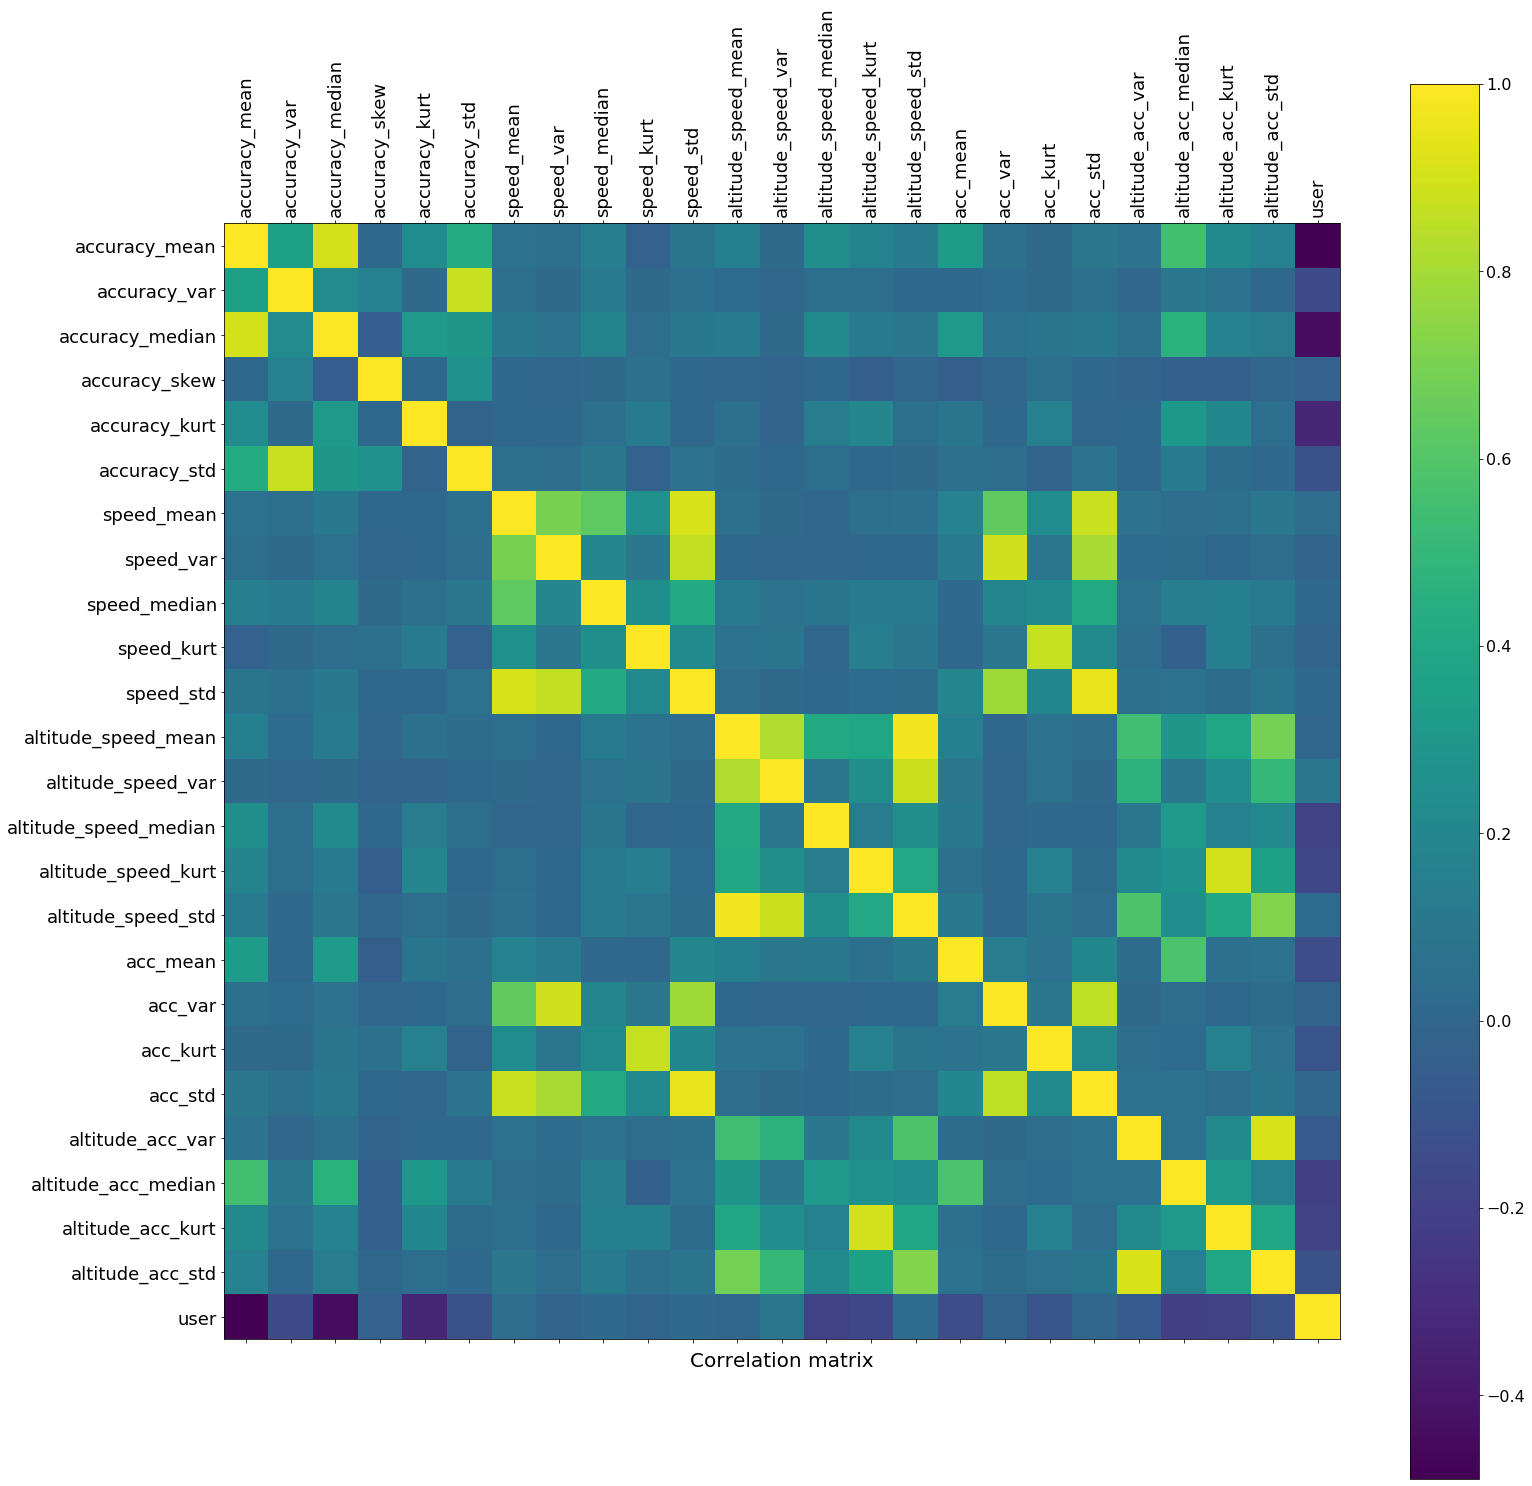

In [12]:
fig = plt.figure(figsize=(25, 25))
plt.matshow(df.corr(), fignum=fig.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=18, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.title("Correlation matrix", fontsize=20, y=-0.03)

In [13]:
corr_matrix = df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_cols = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.7) and column != "user"]
df = df.drop(corr_cols, axis=1)

In [14]:
# df.drop('user', axis=1).boxplot()

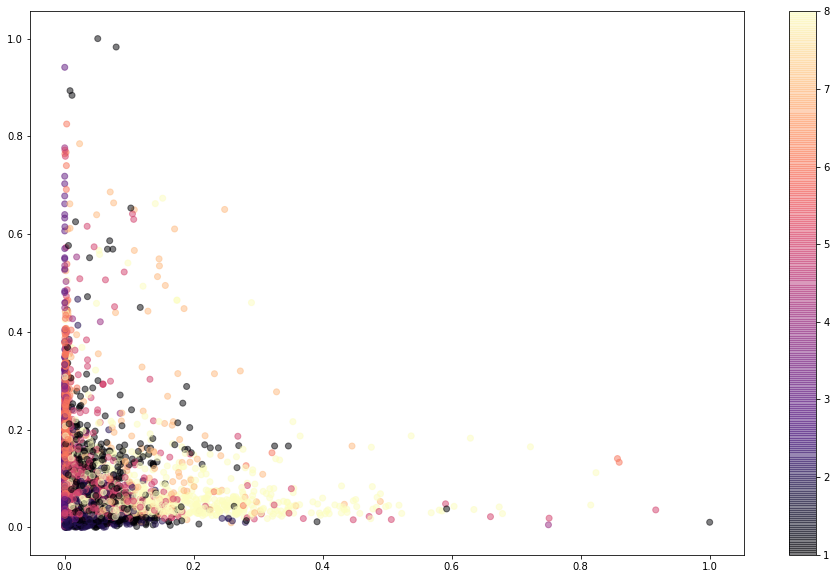

In [23]:
sample = df.sample(10000)
plt.figure(figsize=(16, 10))
plt.scatter(x=sample['altitude_speed_mean'], y=sample['accuracy_kurt'], alpha=0.5, c=sample.user, cmap='magma')
plt.colorbar()
plt.show()

In [16]:
# for user in df.user.unique():
#     for valid_user in df.user.unique():
#         if user != valid_user:
#             print('---------------------------------------------------------------------------')
#             print('Valid user: ', valid_user, 'Extracted user: ', user)
#             print('---------------------------------------------------------------------------')
#             df1, df_ = extract_delayed_user(df.copy(), user)
#             df1['user'] = 0
#             df_ = split_users_into_two_classes(df_.copy(), valid_user)
#             df_ = resample(df_)

#             dataset = df_.to_numpy()
#             X = dataset[:, :-1]
#             y = dataset[:, -1]

#             X_test = df1.to_numpy()[:, :-1]
#             y_test = df1.to_numpy()[:, -1]

#             model.fit(X, y, verbose=False)

#             preds_class = model.predict(X_test)
#             print('Accuracy: ', accuracy_score(preds_class, y_test))

#             sum_ = 0
#             imp = [ (x, i) for x, i in zip(model.feature_importances_, range(len(model.feature_importances_)) )]
#             sorted_ = sorted(imp, key=lambda tup: tup[0])
#             for i in range(len(sorted_)):
#                 if sorted_[i][0] > 5:
#                     print(sorted_[i][1], ': ', df_.columns[sorted_[i][1]], ' - ', sorted_[i][0])

#             print('---------------------------------------------------------------------------')
#             print('---------------------------------------------------------------------------')

## CatBoostClassifier CV

In [17]:
iterations = 100
depth = 6
loss_function = 'Logloss'
l2_leaf_reg = 1
leaf_estimation_iterations = 5
logging_level = 'Silent'

df['labels'] = df['user']

CV_CATBOOST_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    df_ = resample(df.copy())
    df_ = split_users_into_two_classes(df_.copy(), user)
    df_ = resample(df_)
    
    group_labels = df_.labels.to_numpy().copy()
    df_ = df_.drop('labels', axis=1)
    
    dataset = df_.to_numpy().copy()
    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    cv_split = PredefinedSplit(test_fold=get_cv_split(X, y, group_labels, user))
    scoring = ('accuracy', 'balanced_accuracy')
    
    model = CatBoostClassifier(iterations=iterations, depth=depth, loss_function=loss_function, \
                               l2_leaf_reg=l2_leaf_reg, leaf_estimation_iterations=leaf_estimation_iterations,\
                               logging_level=logging_level)
    
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=cv_split, n_jobs=-1)
    accuracy = cv_results['test_accuracy']
    
    CV_CATBOOST_BIG_DICT[str(user)] = {}
    CV_CATBOOST_BIG_DICT[str(user)]["accuracy"] = accuracy.copy()
    CV_CATBOOST_BIG_DICT[str(user)]["mean_accuracy"] = np.mean(accuracy).copy()
    CV_CATBOOST_BIG_DICT[str(user)]["max_accuracy"] = np.max(accuracy).copy()
    CV_CATBOOST_BIG_DICT[str(user)]["min_accuracy"] = np.min(accuracy).copy()
    
    print("CV accuracy list: ", accuracy)
    print("CV mean accuracy: ", np.mean(accuracy))
    print("CV min accuracy: ", np.min(accuracy))
    print("CV max accuracy: ", np.max(accuracy))
    
    print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
CV accuracy list:  [1.         1.         1.         1.         0.98565121 0.9915379 ]
CV mean accuracy:  0.9961981849399068
CV min accuracy:  0.9856512141280354
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  2
--------------------------------------------------------------------------------
CV accuracy list:  [1.         1.         1.         1.         1.         0.40103017]
CV mean accuracy:  0.9001716948736816
CV min accuracy:  0.4010301692420898
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  3
--------------------------------------------------------------------------------
CV accuracy list:  [1.         1.         0.99967807 1.         1.         1.        ]
CV mean accuracy:  0.9999463453519745
CV min accuracy:  0.9996780721118469
CV max accuracy:  1.

## CatBoostClassifier Final Validation

In [18]:
iterations = 100
depth = 6
loss_function = 'Logloss'
l2_leaf_reg = 1
leaf_estimation_iterations = 5
logging_level = 'Silent'

df["labels"] = df["user"]

VALIDATION_CATBOOST_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    VALIDATION_CATBOOST_BIG_DICT[str(user)] = {}

    for ex_user in df.labels.unique():
        if ex_user != user:

            df_ = df.copy()

            df_for_test = []

            df__ = df_[df_.labels == ex_user].copy()
            df_for_test.append(df__)
            df_ = df_.drop(df__.index, axis=0)

            for user_ in df_.labels.unique():
                if user_ != ex_user:
                    test_size = int((0.25 * df_[df_.labels == user_].shape[0]) - 1)
                    df__ = df_[df_.labels == user_].sample(test_size).copy()
                    df_for_test.append(df__)
                    df_ = df_.drop(df__.index, axis=0)

            df_ = resample(df_.copy())
            df_ = split_users_into_two_classes(df_.copy(), user)
            df_ = resample(df_)

            df_ = df_.drop("labels", axis=1)

            dataset = df_.to_numpy().copy()
            np.random.shuffle(dataset)

            X = dataset[:, :-1]
            y = dataset[:, -1]

            model = CatBoostClassifier(iterations=iterations, depth=depth, loss_function=loss_function, \
                                       l2_leaf_reg=l2_leaf_reg, leaf_estimation_iterations=leaf_estimation_iterations, \
                                       logging_level=logging_level)
            model.fit(X, y)

            # Testing

            test_df = pd.concat(df_for_test)

            valid_user_in_test_count = test_df[test_df.labels == user].shape[0]
            ex_user_in_test_count = test_df[test_df.labels == ex_user].shape[0]
            others_in_test_count = [test_df[test_df.labels == x].shape[0] \
                                    for x in test_df.labels.unique() if x != user and x != ex_user]

            min_others_test_count = min(others_in_test_count)

            is_important_min = True
            if min_others_test_count <= ex_user_in_test_count and min_others_test_count <= valid_user_in_test_count:
                is_important_min = False

            new_df_parts = []
            if is_important_min is True:
                part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                other_sample_size = part_size // len(others_in_test_count) + 1

            else:
                part_size_can_be = min_others_test_count * len(others_in_test_count)
                        
                if part_size_can_be > min(valid_user_in_test_count, ex_user_in_test_count):
                    part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                    other_sample_size = part_size // len(others_in_test_count) + 1
                else:
                    part_size = part_size_can_be
                    other_sample_size = min_others_test_count
                    
            new_df_parts.append(test_df[test_df.labels == user].sample(part_size).copy())
            new_df_parts.append(test_df[test_df.labels == ex_user].sample(part_size).copy())

            for x in test_df.labels.unique():
                if x != user and x != ex_user:
                    new_df_parts.append(test_df[test_df.labels == x].sample(other_sample_size).copy())
                    
            test_df = pd.concat(new_df_parts)

            test_df.loc[test_df.labels != user, "user"] = 0
            test_df.loc[test_df.labels == user, "user"] = 1

            print("True: ", test_df[test_df.user == 1].shape)
            print("Shape: ", test_df.shape)
            for x in test_df.labels.unique():
                print("Count ", x, ": ", test_df[test_df.labels == x].shape)

            test_df = test_df.drop("labels", axis=1)

            test_dataset = test_df.to_numpy().copy()
            X_test = test_dataset[:, :-1].copy()
            y_test = test_dataset[:, -1].copy()

            VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user] = {}
            VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user]["y_test"] = y_test.copy()
            VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user]["y_predict"] = model.predict(X_test).copy()
            VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user]["y_proba"] = model.predict_proba(X_test).copy()

            print("Valid user = ", user, ", Extracted user = ", ex_user, "accuracy = ",
                    accuracy_score(VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user]["y_test"], 
                                   VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user]["y_predict"])
                 )

            print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
True:  (930, 16)
Shape:  (2795, 16)
Count  1 :  (930, 16)
Count  2 :  (930, 16)
Count  3 :  (187, 16)
Count  4 :  (187, 16)
Count  5 :  (187, 16)
Count  7 :  (187, 16)
Count  8 :  (187, 16)
Valid user =  1 , Extracted user =  2 accuracy =  0.9996422182468694
--------------------------------------------------------------------------------
True:  (930, 16)
Shape:  (2795, 16)
Count  1 :  (930, 16)
Count  3 :  (930, 16)
Count  2 :  (187, 16)
Count  4 :  (187, 16)
Count  5 :  (187, 16)
Count  7 :  (187, 16)
Count  8 :  (187, 16)
Valid user =  1 , Extracted user =  3 accuracy =  0.9996422182468694
--------------------------------------------------------------------------------
True:  (930, 16)
Shape:  (2795, 16)
Count  1 :  (930, 16)
Count  4 :  (930, 16)
Count  2 :  (187, 16)
Count  3 :  (187, 16)
Count  5 :  (187, 16)
Count  7 :  (187, 16)
Count  8 :  (187, 16)
Valid user =  1 , Extracted user =

True:  (1505, 16)
Shape:  (4515, 16)
Count  5 :  (1505, 16)
Count  1 :  (1505, 16)
Count  2 :  (301, 16)
Count  3 :  (301, 16)
Count  4 :  (301, 16)
Count  7 :  (301, 16)
Count  8 :  (301, 16)
Valid user =  5 , Extracted user =  1 accuracy =  1.0
--------------------------------------------------------------------------------
True:  (1505, 16)
Shape:  (4515, 16)
Count  5 :  (1505, 16)
Count  2 :  (1505, 16)
Count  1 :  (301, 16)
Count  3 :  (301, 16)
Count  4 :  (301, 16)
Count  7 :  (301, 16)
Count  8 :  (301, 16)
Valid user =  5 , Extracted user =  2 accuracy =  1.0
--------------------------------------------------------------------------------
True:  (1505, 16)
Shape:  (4515, 16)
Count  5 :  (1505, 16)
Count  3 :  (1505, 16)
Count  1 :  (301, 16)
Count  2 :  (301, 16)
Count  4 :  (301, 16)
Count  7 :  (301, 16)
Count  8 :  (301, 16)
Valid user =  5 , Extracted user =  3 accuracy =  0.9074197120708749
--------------------------------------------------------------------------------
T

## RandomForestClassifier CV

In [19]:
n_estimators = 100
criterion = 'gini'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
max_features = 'auto'
n_jobs = -1
class_weight = 'balanced'

df['labels'] = df['user']

CV_RFC_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    df_ = resample(df.copy())
    df_ = split_users_into_two_classes(df_.copy(), user)
    df_ = resample(df_)
    
    group_labels = df_.labels.to_numpy().copy()
    df_ = df_.drop('labels', axis=1)
    
    dataset = df_.to_numpy().copy()
    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    cv_split = PredefinedSplit(test_fold=get_cv_split(X, y, group_labels, user))
    scoring = ('accuracy', 'balanced_accuracy')
    
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, \
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                                   max_features=max_features, n_jobs=n_jobs, class_weight=class_weight)
    
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=cv_split, n_jobs=-1)
    accuracy = cv_results['test_accuracy']
    
    CV_RFC_BIG_DICT[str(user)] = {}
    CV_RFC_BIG_DICT[str(user)]["accuracy"] = accuracy.copy()
    CV_RFC_BIG_DICT[str(user)]["mean_accuracy"] = np.mean(accuracy).copy()
    CV_RFC_BIG_DICT[str(user)]["max_accuracy"] = np.max(accuracy).copy()
    CV_RFC_BIG_DICT[str(user)]["min_accuracy"] = np.min(accuracy).copy()
    
    print("CV accuracy list: ", accuracy)
    print("CV mean accuracy: ", np.mean(accuracy))
    print("CV min accuracy: ", np.min(accuracy))
    print("CV max accuracy: ", np.max(accuracy))
    
    print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
CV accuracy list:  [1.         1.         1.         1.         1.         0.99894224]
CV mean accuracy:  0.9998237061564876
CV min accuracy:  0.9989422369389257
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  2
--------------------------------------------------------------------------------
CV accuracy list:  [1.         1.         1.         1.         0.99048013 0.00202355]
CV mean accuracy:  0.8320839465293108
CV min accuracy:  0.0020235467255334807
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  3
--------------------------------------------------------------------------------
CV accuracy list:  [1. 1. 1. 1. 1. 1.]
CV mean accuracy:  1.0
CV min accuracy:  1.0
CV max accuracy:  1.0
-------------------------------------------------------------------------

## RandomForestClassifier Final Validation

In [20]:
n_estimators = 100
criterion = 'gini'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
max_features = 'auto'
n_jobs = -1
class_weight = 'balanced'

df["labels"] = df["user"]

VALIDATION_RFC_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    VALIDATION_RFC_BIG_DICT[str(user)] = {}

    for ex_user in df.labels.unique():
        if ex_user != user:

            df_ = df.copy()

            df_for_test = []

            df__ = df_[df_.labels == ex_user].copy()
            df_for_test.append(df__)
            df_ = df_.drop(df__.index, axis=0)

            for user_ in df_.labels.unique():
                if user_ != ex_user:
                    test_size = int((0.25 * df_[df_.labels == user_].shape[0]) - 1)
                    df__ = df_[df_.labels == user_].sample(test_size).copy()
                    df_for_test.append(df__)
                    df_ = df_.drop(df__.index, axis=0)

            df_ = resample(df_.copy())
            df_ = split_users_into_two_classes(df_.copy(), user)
            df_ = resample(df_)

            df_ = df_.drop("labels", axis=1)

            dataset = df_.to_numpy().copy()
            np.random.shuffle(dataset)

            X = dataset[:, :-1]
            y = dataset[:, -1]

            model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, \
                                           min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                                           max_features=max_features, n_jobs=n_jobs, class_weight=class_weight)
            model.fit(X, y)

            # Testing

            test_df = pd.concat(df_for_test)

            valid_user_in_test_count = test_df[test_df.labels == user].shape[0]
            ex_user_in_test_count = test_df[test_df.labels == ex_user].shape[0]
            others_in_test_count = [test_df[test_df.labels == x].shape[0] \
                                    for x in test_df.labels.unique() if x != user and x != ex_user]

            min_others_test_count = min(others_in_test_count)

            is_important_min = True
            if min_others_test_count <= ex_user_in_test_count and min_others_test_count <= valid_user_in_test_count:
                is_important_min = False

            new_df_parts = []
            if is_important_min is True:
                part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                other_sample_size = part_size // len(others_in_test_count) + 1

            else:
                part_size_can_be = min_others_test_count * len(others_in_test_count)
                        
                if part_size_can_be > min(valid_user_in_test_count, ex_user_in_test_count):
                    part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                    other_sample_size = part_size // len(others_in_test_count) + 1
                else:
                    part_size = part_size_can_be
                    other_sample_size = min_others_test_count
                    
            new_df_parts.append(test_df[test_df.labels == user].sample(part_size).copy())
            new_df_parts.append(test_df[test_df.labels == ex_user].sample(part_size).copy())

            for x in test_df.labels.unique():
                if x != user and x != ex_user:
                    new_df_parts.append(test_df[test_df.labels == x].sample(other_sample_size).copy())
                    
            test_df = pd.concat(new_df_parts)

            test_df.loc[test_df.labels != user, "user"] = 0
            test_df.loc[test_df.labels == user, "user"] = 1

            test_df = test_df.drop("labels", axis=1)

            test_dataset = test_df.to_numpy().copy()
            X_test = test_dataset[:, :-1].copy()
            y_test = test_dataset[:, -1].copy()

            VALIDATION_RFC_BIG_DICT[str(user)][ex_user] = {}
            VALIDATION_RFC_BIG_DICT[str(user)][ex_user]["y_test"] = y_test.copy()
            VALIDATION_RFC_BIG_DICT[str(user)][ex_user]["y_predict"] = model.predict(X_test).copy()
            VALIDATION_RFC_BIG_DICT[str(user)][ex_user]["y_proba"] = model.predict_proba(X_test).copy()

            print("Valid user = ", user, ", Extracted user = ", ex_user, "accuracy = ",
                    accuracy_score(VALIDATION_RFC_BIG_DICT[str(user)][ex_user]["y_test"], 
                                   VALIDATION_RFC_BIG_DICT[str(user)][ex_user]["y_predict"])
                 )

            print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  2 accuracy =  1.0
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  3 accuracy =  0.9996422182468694
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  4 accuracy =  0.9996422182468694
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  5 accuracy =  1.0
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  7 accuracy =  1.0
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  8 accuracy =  0.9996422182468694
--------------------------------------------------------------------------------
Valid User:  2
----------------------------------

## SVC CV

In [ ]:
C = 10
kernel = 'rbf'
degree = 1
gamma = 5

df['labels'] = df['user']

CV_SVC_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    df_ = resample(df.copy())
    df_ = split_users_into_two_classes(df_.copy(), user)
    df_ = resample(df_)
    
    df_.loc[df_.user == 0, 'user'] = -1
    
    group_labels = df_.labels.to_numpy().copy()
    df_ = df_.drop('labels', axis=1)
    
    dataset = df_.to_numpy().copy()
    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    cv_split = PredefinedSplit(test_fold=get_cv_split(X, y, group_labels, user))
    scoring = ('accuracy', 'balanced_accuracy')
    
    model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
    
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=cv_split, n_jobs=-1)
    accuracy = cv_results['test_accuracy']
    
    CV_SVC_BIG_DICT[str(user)] = {}
    CV_SVC_BIG_DICT[str(user)]["accuracy"] = accuracy.copy()
    CV_SVC_BIG_DICT[str(user)]["mean_accuracy"] = np.mean(accuracy).copy()
    CV_SVC_BIG_DICT[str(user)]["max_accuracy"] = np.max(accuracy).copy()
    CV_SVC_BIG_DICT[str(user)]["min_accuracy"] = np.min(accuracy).copy()
    
    print("CV accuracy list: ", accuracy)
    print("CV mean accuracy: ", np.mean(accuracy))
    print("CV min accuracy: ", np.min(accuracy))
    print("CV max accuracy: ", np.max(accuracy))
    
    print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
CV accuracy list:  [1.         1.         1.         1.         1.         0.62826527]
CV mean accuracy:  0.9380442114299731
CV min accuracy:  0.6282652685798381
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  2
--------------------------------------------------------------------------------
CV accuracy list:  [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.65783664e-04]
CV mean accuracy:  0.8334942972774099
CV min accuracy:  0.0009657836644591612
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  3
--------------------------------------------------------------------------------
CV accuracy list:  [1. 1. 1. 1. 1. 1.]
CV mean accuracy:  1.0
CV min accuracy:  1.0
CV max accuracy:  1.0
------------------------------------------------

## SVC Final Validation

In [ ]:
C = 10
kernel = 'rbf'
degree = 1
gamma = 5

df["labels"] = df["user"]

VALIDATION_SVC_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    VALIDATION_SVC_BIG_DICT[str(user)] = {}

    for ex_user in df.labels.unique():
        if ex_user != user:

            df_ = df.copy()

            df_for_test = []

            df__ = df_[df_.labels == ex_user].copy()
            df_for_test.append(df__)
            df_ = df_.drop(df__.index, axis=0)

            for user_ in df_.labels.unique():
                if user_ != ex_user:
                    test_size = int((0.25 * df_[df_.labels == user_].shape[0]) - 1)
                    df__ = df_[df_.labels == user_].sample(test_size).copy()
                    df_for_test.append(df__)
                    df_ = df_.drop(df__.index, axis=0)

            df_ = resample(df_.copy())
            df_ = split_users_into_two_classes(df_.copy(), user)
            df_ = resample(df_)
            
            df_.loc[df_.user == 0, 'user'] = -1

            df_ = df_.drop("labels", axis=1)

            dataset = df_.to_numpy().copy()
            np.random.shuffle(dataset)

            X = dataset[:, :-1]
            y = dataset[:, -1]

            model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
            model.fit(X, y)

            # Testing

            test_df = pd.concat(df_for_test)

            valid_user_in_test_count = test_df[test_df.labels == user].shape[0]
            ex_user_in_test_count = test_df[test_df.labels == ex_user].shape[0]
            others_in_test_count = [test_df[test_df.labels == x].shape[0] \
                                    for x in test_df.labels.unique() if x != user and x != ex_user]

            min_others_test_count = min(others_in_test_count)

            is_important_min = True
            if min_others_test_count <= ex_user_in_test_count and min_others_test_count <= valid_user_in_test_count:
                is_important_min = False

            new_df_parts = []
            if is_important_min is True:
                part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                other_sample_size = part_size // len(others_in_test_count) + 1

            else:
                part_size_can_be = min_others_test_count * len(others_in_test_count)
                        
                if part_size_can_be > min(valid_user_in_test_count, ex_user_in_test_count):
                    part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                    other_sample_size = part_size // len(others_in_test_count) + 1
                else:
                    part_size = part_size_can_be
                    other_sample_size = min_others_test_count
                    
            new_df_parts.append(test_df[test_df.labels == user].sample(part_size).copy())
            new_df_parts.append(test_df[test_df.labels == ex_user].sample(part_size).copy())

            for x in test_df.labels.unique():
                if x != user and x != ex_user:
                    new_df_parts.append(test_df[test_df.labels == x].sample(other_sample_size).copy())
                    
            test_df = pd.concat(new_df_parts)

            test_df.loc[test_df.labels != user, "user"] = -1
            test_df.loc[test_df.labels == user, "user"] = 1

            test_df = test_df.drop("labels", axis=1)

            test_dataset = test_df.to_numpy().copy()
            X_test = test_dataset[:, :-1].copy()
            y_test = test_dataset[:, -1].copy()

            VALIDATION_SVC_BIG_DICT[str(user)][ex_user] = {}
            VALIDATION_SVC_BIG_DICT[str(user)][ex_user]["y_test"] = y_test.copy()
            VALIDATION_SVC_BIG_DICT[str(user)][ex_user]["y_predict"] = model.predict(X_test).copy()
            VALIDATION_SVC_BIG_DICT[str(user)][ex_user]["y_proba"] = model.decision_function(X_test).copy()

            print("Valid user = ", user, ", Extracted user = ", ex_user, "accuracy = ",
                    accuracy_score(VALIDATION_SVC_BIG_DICT[str(user)][ex_user]["y_test"], 
                                   VALIDATION_SVC_BIG_DICT[str(user)][ex_user]["y_predict"])
                 )

            print("--------------------------------------------------------------------------------")

## LogReg CV

In [ ]:
penalty = 'l2'
C = 0.01
solver = 'newton-cg'
max_iter = 1000
n_jobs = -1

df['labels'] = df['user']

CV_LR_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    df_ = resample(df.copy())
    df_ = split_users_into_two_classes(df_.copy(), user)
    df_ = resample(df_)
    
    group_labels = df_.labels.to_numpy().copy()
    df_ = df_.drop('labels', axis=1)
    
    dataset = df_.to_numpy().copy()
    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    cv_split = PredefinedSplit(test_fold=get_cv_split(X, y, group_labels, user))
    scoring = ('accuracy', 'balanced_accuracy')
    
    model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter, n_jobs=n_jobs)
    
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=cv_split, n_jobs=-1)
    accuracy = cv_results['test_accuracy']
    
    CV_LR_BIG_DICT[str(user)] = {}
    CV_LR_BIG_DICT[str(user)]["accuracy"] = accuracy.copy()
    CV_LR_BIG_DICT[str(user)]["mean_accuracy"] = np.mean(accuracy).copy()
    CV_LR_BIG_DICT[str(user)]["max_accuracy"] = np.max(accuracy).copy()
    CV_LR_BIG_DICT[str(user)]["min_accuracy"] = np.min(accuracy).copy()
    
    print("CV accuracy list: ", accuracy)
    print("CV mean accuracy: ", np.mean(accuracy))
    print("CV min accuracy: ", np.min(accuracy))
    print("CV max accuracy: ", np.max(accuracy))
    
    print("--------------------------------------------------------------------------------")

## LogReg Final Validation

In [ ]:
penalty = 'l2'
C = 0.01
solver = 'newton-cg'
max_iter = 1000
n_jobs = -1

df["labels"] = df["user"]

VALIDATION_LR_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    VALIDATION_LR_BIG_DICT[str(user)] = {}

    for ex_user in df.labels.unique():
        if ex_user != user:

            df_ = df.copy()

            df_for_test = []

            df__ = df_[df_.labels == ex_user].copy()
            df_for_test.append(df__)
            df_ = df_.drop(df__.index, axis=0)

            for user_ in df_.labels.unique():
                if user_ != ex_user:
                    test_size = int((0.25 * df_[df_.labels == user_].shape[0]) - 1)
                    df__ = df_[df_.labels == user_].sample(test_size).copy()
                    df_for_test.append(df__)
                    df_ = df_.drop(df__.index, axis=0)

            df_ = resample(df_.copy())
            df_ = split_users_into_two_classes(df_.copy(), user)
            df_ = resample(df_)

            df_ = df_.drop("labels", axis=1)

            dataset = df_.to_numpy().copy()
            np.random.shuffle(dataset)

            X = dataset[:, :-1]
            y = dataset[:, -1]

            model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter, n_jobs=n_jobs)
            model.fit(X, y)

            # Testing

            test_df = pd.concat(df_for_test)

            valid_user_in_test_count = test_df[test_df.labels == user].shape[0]
            ex_user_in_test_count = test_df[test_df.labels == ex_user].shape[0]
            others_in_test_count = [test_df[test_df.labels == x].shape[0] \
                                    for x in test_df.labels.unique() if x != user and x != ex_user]

            min_others_test_count = min(others_in_test_count)

            is_important_min = True
            if min_others_test_count <= ex_user_in_test_count and min_others_test_count <= valid_user_in_test_count:
                is_important_min = False

            new_df_parts = []
            if is_important_min is True:
                part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                other_sample_size = part_size // len(others_in_test_count) + 1

            else:
                part_size_can_be = min_others_test_count * len(others_in_test_count)
                        
                if part_size_can_be > min(valid_user_in_test_count, ex_user_in_test_count):
                    part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                    other_sample_size = part_size // len(others_in_test_count) + 1
                else:
                    part_size = part_size_can_be
                    other_sample_size = min_others_test_count
                    
            new_df_parts.append(test_df[test_df.labels == user].sample(part_size).copy())
            new_df_parts.append(test_df[test_df.labels == ex_user].sample(part_size).copy())

            for x in test_df.labels.unique():
                if x != user and x != ex_user:
                    new_df_parts.append(test_df[test_df.labels == x].sample(other_sample_size).copy())
                    
            test_df = pd.concat(new_df_parts)

            test_df.loc[test_df.labels != user, "user"] = 0
            test_df.loc[test_df.labels == user, "user"] = 1

            test_df = test_df.drop("labels", axis=1)

            test_dataset = test_df.to_numpy().copy()
            X_test = test_dataset[:, :-1].copy()
            y_test = test_dataset[:, -1].copy()

            VALIDATION_LR_BIG_DICT[str(user)][ex_user] = {}
            VALIDATION_LR_BIG_DICT[str(user)][ex_user]["y_test"] = y_test.copy()
            VALIDATION_LR_BIG_DICT[str(user)][ex_user]["y_predict"] = model.predict(X_test).copy()
            VALIDATION_LR_BIG_DICT[str(user)][ex_user]["y_proba"] = model.predict_proba(X_test).copy()

            print("Valid user = ", user, ", Extracted user = ", ex_user, "accuracy = ",
                    accuracy_score(VALIDATION_LR_BIG_DICT[str(user)][ex_user]["y_test"], 
                                   VALIDATION_LR_BIG_DICT[str(user)][ex_user]["y_predict"])
                 )

            print("--------------------------------------------------------------------------------")

In [ ]:
for d in [CV_CATBOOST_BIG_DICT, CV_RFC_BIG_DICT, \
          CV_SVC_BIG_DICT, CV_LR_BIG_DICT]:
    acc = []
    for user, res in d.items():
        print("Valid User: ", user)
        print("--------------------------------------------------------------------------------")
        acc.append(res['mean_accuracy'])
        print('Mean accuracy: ', res['mean_accuracy'])
        print("--------------------------------------------------------------------------------")
    print("MEAN: ", np.mean(acc))

In [ ]:
for d in [VALIDATION_CATBOOST_BIG_DICT, VALIDATION_RFC_BIG_DICT, \
          VALIDATION_SVC_BIG_DICT, VALIDATION_LR_BIG_DICT]:
    
    mean_auc = []
    mean_f = []
    for user, res in d.items():
        print("Valid User: ", user)
        print("--------------------------------------------------------------------------------")
        means_acc = []
        means_prec = []
        means_rec = []
        means_roc = []
        means_f1 = []
        
        for ex_user, ex_res in res.items():
            print('Ex user: ', ex_user)
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

            y_true = ex_res['y_test']
            y_pred = ex_res['y_predict']
            if len(ex_res['y_proba'].shape) > 1 and ex_res['y_proba'].shape[1] > 1:
                y_proba = ex_res['y_proba'][:, 1]
            else:
                y_proba = ex_res['y_proba']
                
            acc = accuracy_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred)
            rec = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            
            means_acc.append(acc)
            means_prec.append(prec)
            means_rec.append(rec)
            means_f1.append(f1)

            print('Accuracy: ', acc)
            print('Precision: ', prec)
            print('Recall: ', rec)
            try:
                roc = roc_auc_score(y_true, y_proba)
                means_roc.append(roc)
                print('ROC-AUC: ', roc)
            except Exception as e:
                print('ROC-AUC: skip')
            print('F1: ', f1)
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
            
        print('Mean accuracy: ', sum(means_acc) / len(means_acc))
        print('mean Precision: ', sum(means_prec) / len(means_prec))
        print('mean Recall: ', sum(means_rec) / len(means_rec))
        if len(means_roc) > 0:
            print('mean ROC-AUC: ', sum(means_roc) / len(means_roc))
            mean_auc.append(sum(means_roc) / len(means_roc))
        print('mean F1: ', sum(means_f1) / len(means_f1))
        mean_f.append(sum(means_f1) / len(means_f1))

        print("--------------------------------------------------------------------------------")
    print("MEAN_F ", np.mean(mean_f))
    print("AUC_F ", np.mean(mean_auc))